# **음성 분류 경진대회**
- 본 포스팅은 음성 데이터에 대한 data augmentation과 feature extraction 등의 내용을 포함하고 있습니다.
- 코드실행은 Google Colab의 CPU, Standard RAM 환경에서 진행했습니다.
- 작성자 : standing-o

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **0. Import Packages**

In [ ]:
import numpy as np
import pandas as pd
import random as rn
import os

from scipy.io import wavfile
import librosa

import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
# reproducibility

def all_seed(seed_num):
    np.random.seed(seed_num)
    rn.seed(seed_num)
    os.environ['PYTHONHASHSEED']=str(seed_num)
    # tf.random.set_seed(seed_num)

seed_num = 42
all_seed(seed_num)

## **1. Load and explore dataset**

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Speech_classification/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Speech_classification/test.csv')

- 📝 한 음성의 waveplot을 확인해보겠습니다.

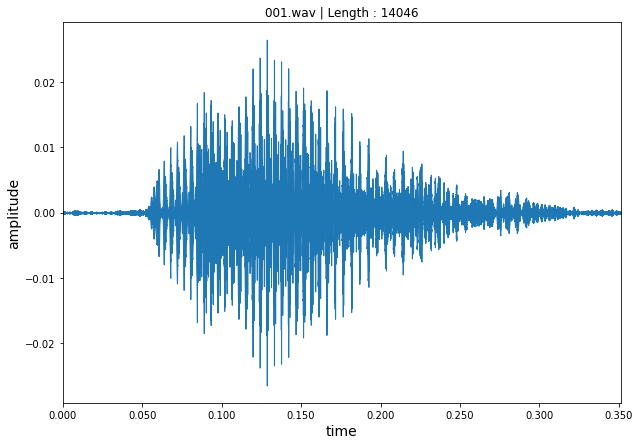

In [ ]:
a_filename = '/content/drive/MyDrive/Speech_classification/dataset/train/001.wav'
samples, sample_rate = librosa.load(a_filename)

plt.figure(figsize=(10, 7))

# plt.plot(np.linspace(0, sample_rate/len(samples), len(samples)), samples)
librosa.display.waveplot(samples, sr=40000)

plt.xlabel('time', fontsize = 14)
plt.ylabel('amplitude', fontsize = 14)
plt.title('001.wav | Length : ' + str(len(samples)))

plt.show()

In [ ]:
print(sample_rate)
print(samples)

22050
[0.00013066 0.00016804 0.00014106 ... 0.00017342 0.00017514 0.        ]


In [ ]:
samples = np.array(samples, dtype='float64')

samples = librosa.resample(samples, sample_rate, 20000)
ipd.Audio(samples, rate=20000)

- 📝 한 음성의 spectrogram을 생성하겠습니다.  
↪ Short term Fourier transform (STFT)의 magnitude를 db 스케일로 변환하여 spectrogram을 생성합니다.

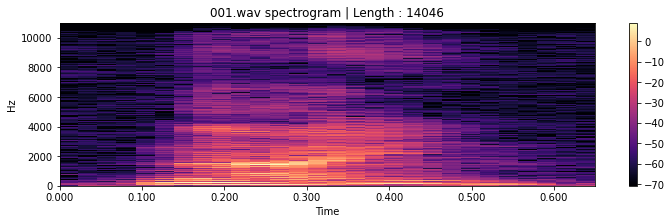

In [ ]:
samples, sample_rate = librosa.load(a_filename)
X = librosa.stft(samples)  # data -> short term FT
Xdb = librosa.amplitude_to_db(abs(X))

plt.figure(figsize=(12, 3))
plt.title('001.wav spectrogram | Length : ' + str(len(samples)))
librosa.display.specshow(Xdb, sr = sample_rate, x_axis='time', y_axis='hz')   
plt.colorbar()
plt.show()

📝 `train.csv`에는 `train` 폴더의 음성 파일 이름과 라벨 컬럼이 포함되어 있습니다. `label` 컬럼은 0~9 정수로 구성됩니다.


In [ ]:
train.head()

,file_name,label
0,001.wav,9
1,002.wav,0
2,004.wav,1
3,005.wav,8
4,006.wav,0


In [ ]:
print(train['label'].unique())

[9 0 1 8 7 4 5 2 6 3]


📝 데이터가 클래스 균형을 이루고 있습니다.

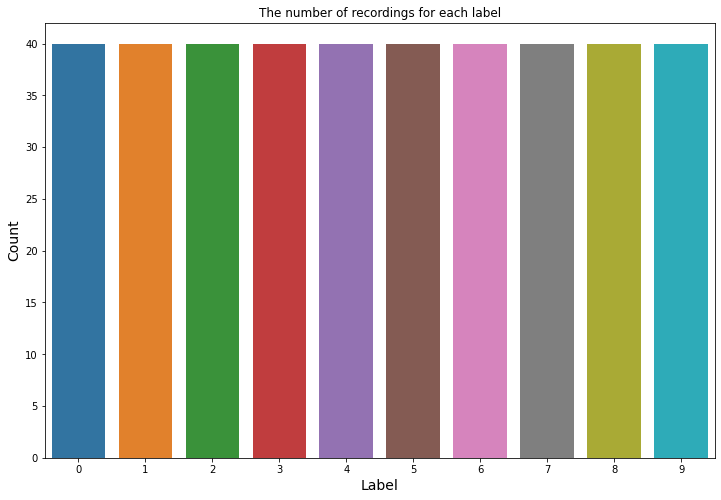

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(train['label'])

plt.title("The number of recordings for each label")
plt.ylabel("Count", fontsize = 14)
plt.xlabel("Label", fontsize = 14)
plt.show()

In [ ]:
file_name = train['file_name']
train_path = '/content/drive/MyDrive/Speech_classification/dataset/train/'

📝 데이터들의 길이가 모두 다릅니다.

In [ ]:
all_shape = []
for f in file_name:
  data, sample_rate = librosa.load(train_path + f, sr = 20000)
  all_shape.append(data.shape)

In [ ]:
print(all_shape[:5])
print("Max :", np.max(all_shape, axis = 0))
print("Min :", np.min(all_shape, axis = 0))

[(12740,), (13126,), (12910,), (9753,), (17572,)]
Max : [19466]
Min : [7139]


## **2. Data augmentation**
- 📝 원래의 음성데이터에 새로운 perturbation 들을 추가하여 새로운 음성데이터를 생성합니다. (모델의 일반화 능력 향상을 위함)
- Noise 추가, time stretching, pitch 변환


In [ ]:
# noise 추가
def noise(sample):
    noise_amp = 0.01*np.random.uniform()*np.amax(sample)
    sample = sample + noise_amp*np.random.normal(size = sample.shape[0])
    return sample

# time stretching
def stretch(sample, rate = 0.8):
    stretch_sample = librosa.effects.time_stretch(sample, rate)
    return stretch_sample

# pitch 변환
def pitch(sample, sampling_rate, pitch_factor = 0.8):
    pitch_sample = librosa.effects.pitch_shift(sample, sampling_rate, pitch_factor)
    return pitch_sample

## **3. Feature Extraction**
- 📝 모델링에 사용하면 도움이 될만한 몇가지 feature extraction 방법을 소개하겠습니다.

#### **1. Zero Crossing Rate (ZCR)**
↪ 특정 프레임이 지속 기간 동안의 신호의 부호(sign) 변화율 i.e. 신호의 부호가 바뀌는 비율
#### **2. Chroma_shift**
↪ Waveform 또는 power spectrogram으로 생성한 chromagram. 
#### **3. Mel spectrum**
↪ 오디오 신호(time domain)에 Fast Fourier Transform (FFT) -> Spectrum (frequency domain)  
↪ Spectrum + 필터링 (Mel filter bank) -> Mel spectrum  
#### **4. MFCC (Mel-Frequency Cepstral Coefficient)**
↪ Mel spectrum에서 Cepstral 분석을 통해 고유한 특성을 추출함
#### **5. RMS (Root Mean Square)**
↪ 오디오 평균 음량 측정


In [ ]:
def extract_features(sample):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y = sample).T, axis=0)
    result=np.hstack((result, zcr)) 

    # Chroma_stft
    stft = np.abs(librosa.stft(sample))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S = stft, sr = sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y = sample, sr = sample_rate).T, axis=0)
    result = np.hstack((result, mel)) 

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y = sample, sr = sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) 

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y = sample).T, axis=0)
    result = np.hstack((result, rms)) 

    return result

📝 Noise 추가, time stretching, pitching 방법들을 통해 음성 데이터 하나 당 (1, 162) 크기의 feature를 (3, 162) 로 증강합니다.

In [ ]:
def get_features(path):

    sample, sample_rate = librosa.load(path)
    
    # without augmentation
    res1 = extract_features(sample)
    result = np.array(res1)
    
    # sample with noise
    noise_sample = noise(sample)
    res2 = extract_features(noise_sample)
    result = np.vstack((result, res2)) 
    
    # sample with stretching and pitching
    str_sample = stretch(sample)
    sample_stretch_pitch = pitch(str_sample, sample_rate)
    res3 = extract_features(sample_stretch_pitch)
    result = np.vstack((result, res3)) 
    
    return result

In [ ]:
labels = train['label']
x, y = [], []
for f, label in zip(file_name, labels):
    feature = get_features(train_path + f)
    for fe in feature:
        x.append(fe)
        y.append(label)

In [ ]:
X = np.array(x)
Y = np.array(y)

print("Shape of X:", np.shape(X))
print("Shape of Y:", np.shape(Y))

Shape of X: (1200, 162)
Shape of Y: (1200,)


#### Reference
[1] [Speech Emotion Recognition by SHIVAM BURNWAL](https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition)

읽어주셔서 감사합니다 :)  
도움이 됐길 바랍니다 👍👍